In [1]:
import pandas as pd

import numpy as np

from functools import reduce

#import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context = 'notebook', #mostly controls relative sizes of things on plot #The base context is “notebook”, and the other contexts are “paper”, “talk”, and “poster”
        style = 'darkgrid', #dict, None, or one of {darkgrid, whitegrid, dark, white, ticks}
        palette = 'deep', # Should be something that color_palette() can process.
        font_scale = 1, 
        color_codes = False, 
        rc = None)

from scipy import stats

# from IPython.core.interactiveshell import InteractiveShell 
# InteractiveShell.ast_node_interactivity = 'last_expr' #s etting = "all" allows multiple outputs to be displayed for a given input cell. don't use w plotting!

from IPython.display import display

%matplotlib notebook
#%matplotlib inline

pd.__version__, sns.__version__ , np.__version__ #,  matplotlib.__version__

('0.23.3', '0.9.0', '1.14.2')

In [2]:
# some functions to load
def head_with_full_columns(pd_in, row_amount = 5):
    with pd.option_context('display.max_columns', len(pd_in.iloc[0])):
        display(pd_in[:row_amount])
        
def balanced_sample(df_in, total_size, rand_state):
    s0 = df_in[df_in['TARGET']==0].sample(n = total_size//2, random_state = rand_state)
    s1 = df_in[df_in['TARGET']==1].sample(n = total_size//2, random_state = rand_state)
    new_df = pd.concat([s0,s1])
    new_df.sort_index(inplace = True)
    return new_df

In [3]:
cd

/Users/DonBunk


In [4]:
raw_data_path = 'Desktop/Google Drive/data_science/Python_Projects/Home_Credit_Default_Risk/raw_loan_data_from_Kaggle/'

agg_data_path = 'Desktop/Google Drive/data_science/Python_Projects/Home_Credit_Default_Risk/aggregation/TEST_aggregation/'

TRAIN_agg_data_path = 'Desktop/Google Drive/data_science/Python_Projects/Home_Credit_Default_Risk/aggregation/TRAIN_aggregation/'

save_path = 'Desktop/Google Drive/data_science/Python_Projects/Home_Credit_Default_Risk/wrangling/TEST_DATA_create_final_wrangled_csv/'

#  Wrangle  application_test

In [5]:
application_TRAIN_df = pd.read_csv(raw_data_path + 'application_train.csv', index_col = 'SK_ID_CURR')
# AMT_ANNUITY appears in multiple files, so rename more specifically. 
# I will keep this renaming as AMT_ANNUITY_from_app_train so it will work will the same pipeline etc inc ase. 
application_TRAIN_df.rename(columns = {"AMT_ANNUITY":"AMT_ANNUITY_from_app_train"} , inplace=True) #index = str, 

In [6]:
application_test_df = pd.read_csv(raw_data_path + 'application_test.csv', index_col = 'SK_ID_CURR')
# AMT_ANNUITY appears in multiple files, so rename more specifically. 
# I will keep this renaming as AMT_ANNUITY_from_app_train so it will work will the same pipeline etc inc ase. 
application_test_df.rename(columns = {"AMT_ANNUITY":"AMT_ANNUITY_from_app_train"} , inplace=True) #index = str, 

## null counts feature, social_counts feature, THEN replace categorical NaNs -> 'NA's, combine cat features <1%. creat DAYS_EMPLOYED = 365243 feature, fix DAYS_EMPLOYED

In [7]:
# dropping some features

# separate out certain features 
housing_feats = [f for f in application_test_df.columns if 'AVG' in f or 'MODE' in f or 'MEDI' in f]
doc_feats = [f for f in application_test_df.columns if 'DOCUMENT' in f]
social_circle_feats = [f for f in application_test_df.columns if 'SOCIAL' in f]
amt_req_feats = [f for f in application_test_df.columns if 'AMT_REQ' in f]

# in another notebook (application_less_important_features) I explore these feats and decide what to drop
# this is a bit confusing: I am forming a list of features to drop from groups I made
# and subtract some features from those groups TO KEEP
# I also add some individual features to drop

groups_of_features_to_drop  = housing_feats + doc_feats + social_circle_feats + amt_req_feats

feats_to_not_drop = {'EMERGENCYSTATE_MODE', 'APARTMENTS_AVG', 'LANDAREA_AVG', 'TOTALAREA_MODE', # these have a bit of info in them
                        'FLAG_DOCUMENT_3','FLAG_DOCUMENT_6', # these have a bit of info in them
                        'OBS_60_CNT_SOCIAL_CIRCLE',   # there is no info here, but keeping it as representative feature 
                        'AMT_REQ_CREDIT_BUREAU_YEAR'  # there is not a lot of info here, but keeping it as representative feature 
                        }

misc_feats_to_drop = ['FLAG_MOBIL',  # this doesn't have much info
                        'FLAG_CONT_MOBILE', # this doesn't have much info
                        'REGION_RATING_CLIENT_W_CITY' # this is HIGHLY correlated (~.95) with REGION_RATING_CLIENT_
                        ]

feats_to_drop = list( set(groups_of_features_to_drop) - set(feats_to_not_drop)) + misc_feats_to_drop


application_TRAIN_df.drop(columns= feats_to_drop, inplace=True)
application_test_df.drop(columns= feats_to_drop, inplace=True)

del housing_feats
del doc_feats
del social_circle_feats
del amt_req_feats
del feats_to_drop

In [8]:
# create a null counts feature
null_counts = application_test_df.isnull().sum(axis = 1)
null_counts.rename('NULL_COUNTS', inplace=True);
application_test_df = pd.concat([application_test_df, null_counts], axis = 1)
del null_counts

In [9]:
# create a null counts just for social features. which may have some corr with TARGET
social_circle_feats = [f for f in application_test_df.columns if 'SOCIAL' in f]
social_null_counts = application_test_df[social_circle_feats].isnull().sum(axis = 1)
social_null_counts.rename('SOCIAL_NULL_COUNTS', inplace=True);
application_test_df = pd.concat([application_test_df, social_null_counts], axis = 1)
del social_circle_feats
del social_null_counts

In [10]:
# replace NaNs in object entries for now is pretty safe. 
f_list = list(application_test_df.select_dtypes('object').columns)
application_test_df[f_list] = application_test_df[f_list].fillna(value = 'No/Av')
del f_list

In [11]:
# for categorical feature than have more than one value <1% in TRAINING data, 
# condensed the <1% values and define a new condensed feature

for feat in application_TRAIN_df.select_dtypes('object').columns:
    percent_srs_TRAIN = application_TRAIN_df[feat].value_counts() /len(application_TRAIN_df[feat])
    percent_less_than_1_TRAIN = list(percent_srs_TRAIN[percent_srs_TRAIN <.01].index)
    
    
    if len(percent_less_than_1_TRAIN) > 1:
        application_test_df[feat + '_condensed'] = application_test_df[feat].apply(lambda x: '<1%' if x in percent_less_than_1_TRAIN else x)
        application_test_df.drop(columns=[feat], inplace=True)
      
    
del feat
del percent_srs_TRAIN
del percent_less_than_1_TRAIN

In [12]:
# creat a DAYS_EMPLOYED = 365243 feature, and then regress away those values

def make_days_empl_col(row):
    if row['DAYS_EMPLOYED']== 365243:
        return 'Y'
    else:
        return 'N'
    
from sklearn import linear_model
reg = linear_model.LinearRegression()

# have to make a list of lists, turn that into np.array, then transpose to has correct shape for the single feature(s) working w here. 
# this is fit to TRAINING DATA!!
no_weird_vals_df = application_TRAIN_df[ application_TRAIN_df['DAYS_EMPLOYED'] !=365243]
reg.fit(np.array([no_weird_vals_df['DAYS_BIRTH'].values]).T, no_weird_vals_df['DAYS_EMPLOYED'].values)

# create a new binary column while I still have the 365243 values.
application_test_df['DAYS_EMPLOYED_eq_365243'] = application_test_df.apply(make_days_empl_col, axis=1)

# replace ['DAYS_EMPLOYED']==365243 with lin reg vals from above

def fix_DAYS_EMPLOYED(row):
    # fill in the weird values
    if row['DAYS_EMPLOYED']== 365243:
        return reg.predict( row['DAYS_BIRTH'] )[0] # need this [0] so it puts value and not a 1-dim array in place
    # fill in any nans while we are at it
    elif np.isnan(row['DAYS_EMPLOYED']):
        return reg.predict( row['DAYS_BIRTH'] )[0] # need this [0] so it puts value and not a 1-dim array in place
    else:
        return row['DAYS_EMPLOYED']
    
application_test_df['DAYS_EMPLOYED'] = application_test_df.apply(fix_DAYS_EMPLOYED, axis = 1)

del reg
del no_weird_vals_df

/anaconda/lib/python3.6/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


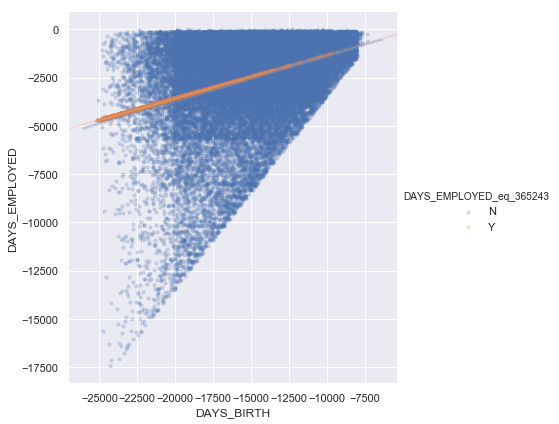

In [13]:
# check that the line and altered data make sense:
sns.lmplot(data = application_test_df,
            x = 'DAYS_BIRTH',
            y = 'DAYS_EMPLOYED',
            hue = 'DAYS_EMPLOYED_eq_365243', 
            fit_reg = True,
            scatter_kws={'alpha':.2,"s":10},
            line_kws={'alpha':.2},
            #palette = ['green','orange'],
            legend_out = True,
            size = 6)

## replacing NaNs

In [14]:
# replace NaNs in CNT_FAMILY_MEMBERS and make it an int
# need to replace NaNs bc pandas does not support NaNs in ints!

replace_dict = {#'EXT_SOURCE_1':.5,
                #'EXT_SOURCE_3':.5, # there are a lot of missing values, but as it stands it is hard to find anything better to impute with
                'CNT_FAM_MEMBERS':application_test_df['CNT_FAM_MEMBERS'].median(), # not many missing, need an integer so use median
                'AMT_ANNUITY_from_app_train':application_test_df['AMT_ANNUITY_from_app_train'].median(), # not many missing
                'AMT_GOODS_PRICE': application_test_df['AMT_GOODS_PRICE'].median(), # not many missing
                'DAYS_LAST_PHONE_CHANGE': application_test_df['DAYS_LAST_PHONE_CHANGE'].median(), # not many missing
                'OWN_CAR_AGE':15, # eyeballed the car age that has equal TARGET = 0, 1 scores                 
                'APARTMENTS_AVG':0, # A LOT MISSING, having a null here likely means 0 for someone filling out the form        
                'LANDAREA_AVG':0, # A LOT MISSING, having a null here likely means 0 for someone filling out the form                  
                'TOTALAREA_MODE':0, # A LOT MISSING, having a null here likely means 0 for someone filling out the form            
                'OBS_60_CNT_SOCIAL_CIRCLE':0, # not many missing, having a null here likely means 0 for someone filling out the form          
                'AMT_REQ_CREDIT_BUREAU_YEAR':0, # A LOT MISSING, having a null here likely means 0 for someone filling out the form    
                }

application_test_df.fillna(replace_dict, inplace=True)

# convert this to int now that NaNs are gone, which it should be
application_test_df['CNT_FAM_MEMBERS'] = application_test_df['CNT_FAM_MEMBERS'].astype(int)

# this is a final catch all in case other missing values appear in test set
#check_nan = application_test_df.isna().any() 

# replace_dict_EXTRA ={}
# for f in check_nan[check_nan==True].index:
#     replace_dict_EXTRA[f]=application_test_df[f].median()
    
# if replace_dict_EXTRA:
#     print('There were additional replacements!')
#     application_test_df.fillna(replace_dict_EXTRA, inplace=True)

In [15]:
test_1 = application_test_df[application_test_df['EXT_SOURCE_1'].isnull()][['CODE_GENDER','DAYS_BIRTH','EXT_SOURCE_1']].sample(n =5, random_state = 0)

In [16]:
test_2 = application_test_df[application_test_df['EXT_SOURCE_2'].isnull()][['REGION_RATING_CLIENT','DAYS_BIRTH','EXT_SOURCE_2']].sample(n =5, random_state = 3)

In [17]:
test_3 = application_test_df[application_test_df['EXT_SOURCE_3'].isnull()][['DAYS_BIRTH','EXT_SOURCE_3']].sample(n =5, random_state = 0)

In [18]:
# this is a bit slow, but faster than only applying to nan values and then replacing in a loop 
male_df = application_test_df[application_test_df['CODE_GENDER']=='M'][['DAYS_BIRTH','EXT_SOURCE_1']]
male_df = male_df[male_df['EXT_SOURCE_1'].notna()]
m_s, m_i, r_value, p_value, std_err = stats.linregress(male_df)

female_df = application_test_df[application_test_df['CODE_GENDER']=='F'][['DAYS_BIRTH','EXT_SOURCE_1']]
female_df = female_df[female_df['EXT_SOURCE_1'].notna()]
f_s, f_i, r_value, p_value, std_err = stats.linregress(female_df)

nogender_df = application_test_df[['DAYS_BIRTH','EXT_SOURCE_1']]
nogender_df = nogender_df[nogender_df['EXT_SOURCE_1'].notna()]
ng_s, ng_i, r_value, p_value, std_err = stats.linregress(nogender_df)

def EXT1_replace(row):
    if np.isnan(row['EXT_SOURCE_1']) ==False:
        return row['EXT_SOURCE_1']
    else:
        if row['CODE_GENDER']=='M':
            return m_s*row['DAYS_BIRTH'] + m_i
        if row['CODE_GENDER']=='F':
            return f_s*row['DAYS_BIRTH'] + f_i
        if row['CODE_GENDER']=='XNA':
            return ng_s*row['DAYS_BIRTH'] + ng_i
    
application_test_df['EXT_SOURCE_1'] = application_test_df.apply(EXT1_replace, axis = 1)

del male_df
del female_df
del nogender_df
del  r_value, p_value, std_err

In [19]:
# check 
display(test_1)
display(application_test_df.loc[test_1.index.values, ['CODE_GENDER','DAYS_BIRTH','EXT_SOURCE_1']])

,CODE_GENDER,DAYS_BIRTH,EXT_SOURCE_1
SK_ID_CURR,,,
201751,F,-19074,NaN
178353,M,-16397,NaN
406129,F,-22397,NaN
172804,F,-12042,NaN
188521,M,-22240,NaN


,CODE_GENDER,DAYS_BIRTH,EXT_SOURCE_1
SK_ID_CURR,,,
201751,F,-19074,0.629041
178353,M,-16397,0.476558
406129,F,-22397,0.710293
172804,F,-12042,0.457099
188521,M,-22240,0.639027


In [20]:
# this is a bit slow, but faster than only applying to nan values and then replacing in a loop 
r1_df = application_test_df[application_test_df['REGION_RATING_CLIENT']==1][['DAYS_BIRTH','EXT_SOURCE_2']]
r1_df = r1_df[r1_df['EXT_SOURCE_2'].notna()]
r1_s, r1_i, r_value, p_value, std_err = stats.linregress(r1_df)

r2_df = application_test_df[application_test_df['REGION_RATING_CLIENT']==2][['DAYS_BIRTH','EXT_SOURCE_2']]
r2_df = r2_df[r2_df['EXT_SOURCE_2'].notna()]
r2_s, r2_i, r_value, p_value, std_err = stats.linregress(r2_df)

r3_df = application_test_df[application_test_df['REGION_RATING_CLIENT']==3][['DAYS_BIRTH','EXT_SOURCE_2']]
r3_df = r3_df[r3_df['EXT_SOURCE_2'].notna()]
r3_s, r3_i, r_value, p_value, std_err = stats.linregress(r3_df)

def EXT2_replace(row):
    if np.isnan(row['EXT_SOURCE_2']) ==False:
        return row['EXT_SOURCE_2']
    else:
        if row['REGION_RATING_CLIENT']==1:
            return r1_s*row['DAYS_BIRTH'] + r1_i
        if row['REGION_RATING_CLIENT']==2:
            return r2_s*row['DAYS_BIRTH'] + r2_i
        if row['REGION_RATING_CLIENT']==3:
            return r3_s*row['DAYS_BIRTH'] + r3_i
    
application_test_df['EXT_SOURCE_2'] = application_test_df.apply(EXT2_replace, axis = 1)

del r1_df, r2_df, r3_df
del r_value, p_value, std_err

In [21]:
# check
display(test_2)
display(application_test_df.loc[test_2.index.values,['REGION_RATING_CLIENT','DAYS_BIRTH','EXT_SOURCE_2']])

,REGION_RATING_CLIENT,DAYS_BIRTH,EXT_SOURCE_2
SK_ID_CURR,,,
392730,2,-10862,NaN
450310,2,-11659,NaN
355560,2,-21895,NaN
405125,2,-8842,NaN
327587,2,-10383,NaN


,REGION_RATING_CLIENT,DAYS_BIRTH,EXT_SOURCE_2
SK_ID_CURR,,,
392730,2,-10862,0.493423
450310,2,-11659,0.497323
355560,2,-21895,0.547416
405125,2,-8842,0.483537
327587,2,-10383,0.491079


In [22]:
# this is a bit slow, but faster than only applying to nan values and then replacing in a loop 
e3_df = application_test_df[['DAYS_BIRTH','EXT_SOURCE_3']]
e3_df = e3_df[e3_df['EXT_SOURCE_3'].notna()]
e3_s, e3_i, r_value, p_value, std_err = stats.linregress(e3_df)

def EXT3_replace(row):
    if np.isnan(row['EXT_SOURCE_3']) ==False:
        return row['EXT_SOURCE_3']
    else:
        return e3_s*row['DAYS_BIRTH'] + e3_i
    
application_test_df['EXT_SOURCE_3'] = application_test_df.apply(EXT3_replace, axis = 1)

del e3_df
del r_value, p_value, std_err

In [23]:
# check
display(test_3)
display(application_test_df.loc[test_3.index.values,['DAYS_BIRTH','EXT_SOURCE_3']])

,DAYS_BIRTH,EXT_SOURCE_3
SK_ID_CURR,,
219688,-14158,NaN
322841,-20942,NaN
277668,-14098,NaN
420278,-9788,NaN
354173,-12408,NaN


,DAYS_BIRTH,EXT_SOURCE_3
SK_ID_CURR,,
219688,-14158,0.483865
322841,-20942,0.538123
277668,-14098,0.483385
420278,-9788,0.448914
354173,-12408,0.469869


In [24]:
application_test_df.isnull().any()

NAME_CONTRACT_TYPE             False
CODE_GENDER                    False
FLAG_OWN_CAR                   False
FLAG_OWN_REALTY                False
CNT_CHILDREN                   False
AMT_INCOME_TOTAL               False
AMT_CREDIT                     False
AMT_ANNUITY_from_app_train     False
AMT_GOODS_PRICE                False
NAME_EDUCATION_TYPE            False
NAME_FAMILY_STATUS             False
REGION_POPULATION_RELATIVE     False
DAYS_BIRTH                     False
DAYS_EMPLOYED                  False
DAYS_REGISTRATION              False
DAYS_ID_PUBLISH                False
OWN_CAR_AGE                    False
FLAG_EMP_PHONE                 False
FLAG_WORK_PHONE                False
FLAG_PHONE                     False
FLAG_EMAIL                     False
CNT_FAM_MEMBERS                False
REGION_RATING_CLIENT           False
WEEKDAY_APPR_PROCESS_START     False
HOUR_APPR_PROCESS_START        False
REG_REGION_NOT_LIVE_REGION     False
REG_REGION_NOT_WORK_REGION     False
L

In [25]:
application_test_df.isnull().values.any()

False

## create new features (log and pwr of continuous features)

In [26]:
# these were explored in plots in a separate notebook

this_feat = 'AMT_INCOME_TOTAL'
application_test_df['log_'+this_feat] = np.log10( application_test_df[this_feat] + 1 ) 

this_feat = 'AMT_CREDIT'
application_test_df['log_'+this_feat] = np.log10( application_test_df[this_feat] + 1 ) 

this_feat = 'AMT_ANNUITY_from_app_train'
application_test_df['pwr_'+this_feat] = (application_test_df[this_feat])**(1/4)

this_feat = 'AMT_GOODS_PRICE'
application_test_df['log_'+this_feat] = np.log10( application_test_df[this_feat] + 1 ) 

this_feat = 'REGION_POPULATION_RELATIVE'
application_test_df['pwr_'+this_feat] = (application_test_df[this_feat])**(1/4)

this_feat = 'DAYS_REGISTRATION' 
application_test_df['pwr_'+this_feat] = (-application_test_df[this_feat])**(1/2)

this_feat = 'OWN_CAR_AGE'
application_test_df['pwr_'+this_feat] = (+application_test_df[this_feat])**(1/2)

this_feat = 'DAYS_LAST_PHONE_CHANGE'
application_test_df['pwr_'+this_feat] = (-application_test_df[this_feat])**(1/2)

this_feat = 'DAYS_EMPLOYED'
application_test_df['pwr_'+this_feat] = (-application_test_df[this_feat])**(1/8)

this_feat = 'DAYS_ID_PUBLISH'
application_test_df['pwr_'+this_feat] = (-application_test_df[this_feat])**(1/1.8)
 
feats_do_drop = ['AMT_INCOME_TOTAL',
                 'AMT_CREDIT',
                 'AMT_ANNUITY_from_app_train',
                 'AMT_GOODS_PRICE',
                 'REGION_POPULATION_RELATIVE',
                 'DAYS_REGISTRATION',
                 'OWN_CAR_AGE',
                 'DAYS_LAST_PHONE_CHANGE',
                 'DAYS_EMPLOYED',
                 'DAYS_ID_PUBLISH',
                  ]

application_test_df.drop(columns=feats_do_drop, inplace=True)

In [27]:
application_test_df.isnull().any()

NAME_CONTRACT_TYPE                False
CODE_GENDER                       False
FLAG_OWN_CAR                      False
FLAG_OWN_REALTY                   False
CNT_CHILDREN                      False
NAME_EDUCATION_TYPE               False
NAME_FAMILY_STATUS                False
DAYS_BIRTH                        False
FLAG_EMP_PHONE                    False
FLAG_WORK_PHONE                   False
FLAG_PHONE                        False
FLAG_EMAIL                        False
CNT_FAM_MEMBERS                   False
REGION_RATING_CLIENT              False
WEEKDAY_APPR_PROCESS_START        False
HOUR_APPR_PROCESS_START           False
REG_REGION_NOT_LIVE_REGION        False
REG_REGION_NOT_WORK_REGION        False
LIVE_REGION_NOT_WORK_REGION       False
REG_CITY_NOT_LIVE_CITY            False
REG_CITY_NOT_WORK_CITY            False
LIVE_CITY_NOT_WORK_CITY           False
EXT_SOURCE_1                      False
EXT_SOURCE_2                      False
EXT_SOURCE_3                      False


In [28]:
application_test_df.isnull().values.any()

False

## save as csv

In [29]:
application_test_df.to_csv(save_path + 'application_test_df_cleaned_final.csv', columns = list(application_test_df.columns))

In [30]:
del application_test_df

# bureau wrangling

In [31]:
best_feats = ['SK_ID_CURR',
              'CREDIT_CURRENCY_mode', 
              'CREDIT_ACTIVE_mode', 
              'CREDIT_TYPE_mode',
              'DAYS_CREDIT_min',
              'DAYS_CREDIT_mean',
              'DAYS_ENDDATE_FACT_min',
              'DAYS_CREDIT_median',
              'DAYS_ENDDATE_FACT_median',
            # 'AMT_ANNUITY_from_bureau_mean', # this doesn't have enough non null vals
              'AMT_CREDIT_SUM_DEBT_mean',
              'DAYS_CREDIT_ENDDATE_mean', 
              'DAYS_CREDIT_UPDATE_mean'
                ]

In [32]:
bureau_df_aggregated_final_df = pd.read_csv(agg_data_path + 'bureau_df_aggregated_final.csv', index_col='SK_ID_CURR', usecols=best_feats)

bureau_df_aggregated_final_df_TRAIN = pd.read_csv(TRAIN_agg_data_path + 'bureau_df_aggregated_final.csv', index_col='SK_ID_CURR', usecols=best_feats)

In [33]:
bureau_df_aggregated_final_df.info(verbose = True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48744 entries, 100001 to 456250
Data columns (total 11 columns):
DAYS_CREDIT_ENDDATE_mean    41984 non-null float64
DAYS_ENDDATE_FACT_median    37800 non-null float64
DAYS_ENDDATE_FACT_min       37800 non-null float64
AMT_CREDIT_SUM_DEBT_mean    41308 non-null float64
DAYS_CREDIT_mean            42320 non-null float64
DAYS_CREDIT_median          42320 non-null float64
DAYS_CREDIT_min             42320 non-null float64
DAYS_CREDIT_UPDATE_mean     42320 non-null float64
CREDIT_ACTIVE_mode          42320 non-null object
CREDIT_CURRENCY_mode        42320 non-null object
CREDIT_TYPE_mode            42320 non-null object
dtypes: float64(8), object(3)
memory usage: 4.5+ MB


In [34]:
# replace NaNs in object entries for now is pretty safe. 
f_list = list(bureau_df_aggregated_final_df.select_dtypes('object').columns)
bureau_df_aggregated_final_df[f_list] = bureau_df_aggregated_final_df[f_list].fillna(value = 'No/Av')
del f_list

In [35]:
# for categorical feature than have more than one value <1%, condensed the <1% values and define a new condensed feature

for feat in bureau_df_aggregated_final_df_TRAIN.select_dtypes('object').columns:
    percent_srs_TRAIN = bureau_df_aggregated_final_df_TRAIN[feat].value_counts() /len(bureau_df_aggregated_final_df_TRAIN[feat])
    percent_less_than_1_TRAIN = list(percent_srs_TRAIN[percent_srs_TRAIN <.01].index)
    
    if len(percent_less_than_1_TRAIN)>1:
        bureau_df_aggregated_final_df[feat + '_condensed'] = bureau_df_aggregated_final_df[feat].apply(lambda x: '<1%' if x in percent_less_than_1_TRAIN else x)
        bureau_df_aggregated_final_df.drop(columns=[feat], inplace=True)
      
del feat
del percent_srs_TRAIN
del percent_less_than_1_TRAIN

In [36]:
def log_modulus_transformation(x):
    return np.sign(x)*np.log10( np.abs(x)+1)

def pwr_transformation(x,pwr):
    return np.sign(x)*( np.abs(x) )**pwr

In [37]:
# TRANSFORMATIONS, then drop original features. 

bureau_df_aggregated_final_df['pwr_DAYS_CREDIT_mean'] = pwr_transformation(bureau_df_aggregated_final_df['DAYS_CREDIT_mean'], 1/1.7)
bureau_df_aggregated_final_df['pwr_DAYS_ENDDATE_FACT_min'] = pwr_transformation(bureau_df_aggregated_final_df['DAYS_ENDDATE_FACT_min'],1/1.3)
bureau_df_aggregated_final_df['pwr_DAYS_CREDIT_median'] = pwr_transformation(bureau_df_aggregated_final_df['DAYS_CREDIT_median'],1/2)
bureau_df_aggregated_final_df['pwr_DAYS_ENDDATE_FACT_median'] = pwr_transformation(bureau_df_aggregated_final_df['DAYS_ENDDATE_FACT_median'],1/2)
bureau_df_aggregated_final_df['LogMod_AMT_CREDIT_SUM_DEBT_mean'] = log_modulus_transformation(bureau_df_aggregated_final_df['AMT_CREDIT_SUM_DEBT_mean'])
bureau_df_aggregated_final_df['pwr_DAYS_CREDIT_ENDDATE_mean'] = pwr_transformation(bureau_df_aggregated_final_df['DAYS_CREDIT_ENDDATE_mean'], .65)
bureau_df_aggregated_final_df['pwr_DAYS_CREDIT_UPDATE_mean'] = pwr_transformation(bureau_df_aggregated_final_df['DAYS_CREDIT_UPDATE_mean'],.2)

bureau_df_aggregated_final_df.drop(columns=['DAYS_CREDIT_mean',
                                            'DAYS_ENDDATE_FACT_min',                                            
                                            'DAYS_CREDIT_median',
                                            'DAYS_ENDDATE_FACT_median',   
                                            'AMT_CREDIT_SUM_DEBT_mean',
                                            'DAYS_CREDIT_ENDDATE_mean',
                                            'DAYS_CREDIT_UPDATE_mean',
                                            ], inplace=True)

In [38]:
replace_dict = {'DAYS_CREDIT_min':-1262,
                'pwr_DAYS_CREDIT_mean':54,
                'pwr_DAYS_ENDDATE_FACT_min':134,
                'pwr_DAYS_CREDIT_median':26,
                'pwr_DAYS_ENDDATE_FACT_median':22,
                'LogMod_AMT_CREDIT_SUM_DEBT_mean':bureau_df_aggregated_final_df['LogMod_AMT_CREDIT_SUM_DEBT_mean'].median(),
                'pwr_DAYS_CREDIT_ENDDATE_mean':0,
                'pwr_DAYS_CREDIT_UPDATE_mean':-3.23,    
                }

bureau_df_aggregated_final_df.fillna(replace_dict, inplace=True)

In [39]:
bureau_df_aggregated_final_df.info(verbose = True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48744 entries, 100001 to 456250
Data columns (total 11 columns):
DAYS_CREDIT_min                    48744 non-null float64
CREDIT_ACTIVE_mode                 48744 non-null object
CREDIT_CURRENCY_mode_condensed     48744 non-null object
CREDIT_TYPE_mode_condensed         48744 non-null object
pwr_DAYS_CREDIT_mean               48744 non-null float64
pwr_DAYS_ENDDATE_FACT_min          48744 non-null float64
pwr_DAYS_CREDIT_median             48744 non-null float64
pwr_DAYS_ENDDATE_FACT_median       48744 non-null float64
LogMod_AMT_CREDIT_SUM_DEBT_mean    48744 non-null float64
pwr_DAYS_CREDIT_ENDDATE_mean       48744 non-null float64
pwr_DAYS_CREDIT_UPDATE_mean        48744 non-null float64
dtypes: float64(8), object(3)
memory usage: 4.5+ MB


In [40]:
bureau_df_aggregated_final_df.to_csv(save_path + 'bureau_df_aggregated_wrangled_final.csv', columns = list(bureau_df_aggregated_final_df.columns))

In [41]:
del bureau_df_aggregated_final_df

# installments payments wrangling

In [42]:
best_feats = ['SK_ID_CURR',
              'NUM_OF_LOANS',
              'DAYS_PAYMENT_LATE_median',
              'DAYS_PAYMENT_LATE_sd',
              'NUM_TIMES_LATE',
              'NUM_TIMES_EARLY',
              'AMT_OVERPAY_MEAN',
              'AMT_OVERPAY_SD',
              'NUM_TIMES_OVERPAY',
              'TERMS_CHANGE_TIMES',
              'NUM_INSTALMENT_VERSION_max',
              'NUM_INSTALMENT_VERSION_min',
              'DAYS_INSTALMENT_mean',
              'DAYS_INSTALMENT_min',
              'DAYS_ENTRY_PAYMENT_mean',
              'DAYS_ENTRY_PAYMENT_min',
              'AMT_INSTALMENT_mean',
              'AMT_INSTALMENT_max',
              'AMT_INSTALMENT_min',
              'AMT_PAYMENT_mean',
              'AMT_PAYMENT_max',
              'AMT_PAYMENT_min',
              'NUM_INSTALMENT_NUMBER_mean',
              'NUM_INSTALMENT_NUMBER_max',
             ]            
              
#               'NUM_INSTALMENT_VERSION_min',
#               'DAYS_INSTALMENT_mean',
#               'DAYS_INSTALMENT_min',
#               'DAYS_ENTRY_PAYMENT_median',
#               'DAYS_ENTRY_PAYMENT_min',
#               'AMT_INSTALMENT_mean',
#               'AMT_INSTALMENT_max',
#               'AMT_INSTALMENT_min',
#               'AMT_PAYMENT_mean',
#               'AMT_PAYMENT_max',
#               'AMT_PAYMENT_min',
#               'NUM_INSTALMENT_NUMBER_mean',
#             ]

In [43]:
installments_payments_df_agg_final = pd.read_csv(agg_data_path + 'installments_payments_df_final.csv', index_col='SK_ID_CURR', usecols=best_feats)

In [44]:
installments_payments_df_agg_final.info(verbose = True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48744 entries, 100001 to 456250
Data columns (total 23 columns):
NUM_OF_LOANS                  47944 non-null float64
DAYS_PAYMENT_LATE_median      47943 non-null float64
DAYS_PAYMENT_LATE_sd          47663 non-null float64
NUM_TIMES_LATE                47944 non-null float64
NUM_TIMES_EARLY               47944 non-null float64
AMT_OVERPAY_MEAN              47656 non-null float64
AMT_OVERPAY_SD                47427 non-null float64
NUM_TIMES_OVERPAY             47944 non-null float64
TERMS_CHANGE_TIMES            47944 non-null float64
NUM_INSTALMENT_VERSION_max    47944 non-null float64
NUM_INSTALMENT_VERSION_min    47944 non-null float64
DAYS_INSTALMENT_mean          47944 non-null float64
DAYS_INSTALMENT_min           47944 non-null float64
DAYS_ENTRY_PAYMENT_mean       47943 non-null float64
DAYS_ENTRY_PAYMENT_min        47943 non-null float64
AMT_INSTALMENT_mean           47944 non-null float64
AMT_INSTALMENT_max            47944 n

In [45]:
def log_modulus_transformation(x):
    return np.sign(x)*np.log10( np.abs(x)+1)

def pwr_transformation(x,pwr):
    return np.sign(x)*( np.abs(x) )**pwr

def transform_drop_replace(df_in, old_feat, trans,  replace_w, exp=0):
    
    if trans=='pwr':
        new_feat = 'pwr_'+ old_feat
        df_in[new_feat] = pwr_transformation(df_in[old_feat],exp) 
        df_in.drop(columns = [old_feat], inplace = True)
        
        if type(replace_w)==int:
            df_in.fillna({new_feat:replace_w}, inplace = True)
        elif replace_w == 'median':
            df_in.fillna({new_feat:df_in[new_feat].median()}, inplace = True)
        elif replace_w == 'mean':
            df_in.fillna({new_feat:df_in[new_feat].mean()}, inplace = True)
        
    if trans=='logmod':
        new_feat = 'LogMod_'+ old_feat
        df_in[new_feat] = log_modulus_transformation(df_in[old_feat]) 
        df_in.drop(columns = [old_feat], inplace = True)
        
        if type(replace_w)==int:
            df_in.fillna({new_feat:replace_w}, inplace = True)
        elif replace_w == 'median':
            df_in.fillna({new_feat:df_in[new_feat].median()}, inplace = True)
        elif replace_w == 'mean':
            df_in.fillna({new_feat:df_in[new_feat].mean()}, inplace = True)
        

In [46]:
# TRANSFORMATIONS, then drop original features. 


transform_drop_replace(df_in = installments_payments_df_agg_final, 
                       old_feat = 'DAYS_PAYMENT_LATE_median', 
                       trans = 'pwr', 
                       replace_w = 'median',
                       exp = 1/1.7, 
                      )

transform_drop_replace(df_in = installments_payments_df_agg_final, 
                       old_feat ='DAYS_PAYMENT_LATE_sd', 
                       trans = 'logmod',  
                       replace_w = 'median',
                       )

transform_drop_replace(df_in = installments_payments_df_agg_final, 
                       old_feat ='NUM_TIMES_LATE', 
                       trans = 'pwr', 
                       exp = 1/1.5, 
                       replace_w = 'median')

transform_drop_replace(df_in = installments_payments_df_agg_final, 
                       old_feat ='NUM_TIMES_EARLY', 
                       trans = 'logmod', 
                       replace_w ='median')


transform_drop_replace(df_in = installments_payments_df_agg_final, 
                       old_feat = 'TERMS_CHANGE_TIMES', 
                       trans = 'pwr', 
                       exp = 1/2, 
                       replace_w ='median')

transform_drop_replace(df_in = installments_payments_df_agg_final, 
                       old_feat = 'DAYS_INSTALMENT_mean', 
                       trans = 'pwr', 
                       exp = 1/3.5, 
                       replace_w ='median')

transform_drop_replace(df_in = installments_payments_df_agg_final, 
                       old_feat ='DAYS_ENTRY_PAYMENT_mean', 
                       trans = 'pwr', 
                       exp = 1/3, 
                       replace_w ='median')
                       
transform_drop_replace(df_in = installments_payments_df_agg_final, 
                       old_feat = 'AMT_INSTALMENT_mean', 
                       trans = 'logmod', 
                       replace_w = 'median')       
                       
transform_drop_replace(df_in = installments_payments_df_agg_final, 
                       old_feat = 'AMT_INSTALMENT_max', 
                       trans = 'pwr', 
                       exp = 1/6, 
                       replace_w ='median')
                       
transform_drop_replace(df_in = installments_payments_df_agg_final, 
                       old_feat = 'AMT_INSTALMENT_min', 
                       trans = 'pwr', 
                       exp = 1/4, 
                       replace_w ='median')                       
                       
transform_drop_replace(df_in = installments_payments_df_agg_final, 
                       old_feat = 'AMT_PAYMENT_mean', 
                       trans = 'logmod', 
                       replace_w = 'median')                       

transform_drop_replace(df_in = installments_payments_df_agg_final, 
                       old_feat = 'AMT_PAYMENT_max', 
                       trans = 'logmod', 
                       replace_w = 'median')                       
                       
transform_drop_replace(df_in = installments_payments_df_agg_final, 
                       old_feat = 'AMT_PAYMENT_min', 
                       trans = 'pwr', 
                       exp =1/5.2, 
                       replace_w = 'median')                       
                       
transform_drop_replace(df_in = installments_payments_df_agg_final, 
                       old_feat = 'NUM_INSTALMENT_NUMBER_mean', 
                       trans = 'logmod', 
                       replace_w = 'median')                       
                       
transform_drop_replace(df_in = installments_payments_df_agg_final, 
                       old_feat = 'NUM_INSTALMENT_NUMBER_max', 
                       trans = 'logmod', 
                       replace_w = 'median')

In [47]:
remaining_replace_list=['NUM_OF_LOANS',
                        'AMT_OVERPAY_MEAN',
                        'AMT_OVERPAY_SD',
                        'NUM_TIMES_OVERPAY',
                        'NUM_INSTALMENT_VERSION_max',
                        'NUM_INSTALMENT_VERSION_min',
                        'DAYS_INSTALMENT_min',
                        'DAYS_ENTRY_PAYMENT_min', 
                       ]
    
for f in remaining_replace_list:
    installments_payments_df_agg_final.fillna({f:installments_payments_df_agg_final[f].median()}, inplace=True)

In [48]:
installments_payments_df_agg_final.info(verbose = True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48744 entries, 100001 to 456250
Data columns (total 23 columns):
NUM_OF_LOANS                         48744 non-null float64
AMT_OVERPAY_MEAN                     48744 non-null float64
AMT_OVERPAY_SD                       48744 non-null float64
NUM_TIMES_OVERPAY                    48744 non-null float64
NUM_INSTALMENT_VERSION_max           48744 non-null float64
NUM_INSTALMENT_VERSION_min           48744 non-null float64
DAYS_INSTALMENT_min                  48744 non-null float64
DAYS_ENTRY_PAYMENT_min               48744 non-null float64
pwr_DAYS_PAYMENT_LATE_median         48744 non-null float64
LogMod_DAYS_PAYMENT_LATE_sd          48744 non-null float64
pwr_NUM_TIMES_LATE                   48744 non-null float64
LogMod_NUM_TIMES_EARLY               48744 non-null float64
pwr_TERMS_CHANGE_TIMES               48744 non-null float64
pwr_DAYS_INSTALMENT_mean             48744 non-null float64
pwr_DAYS_ENTRY_PAYMENT_mean          48744 no

In [49]:
installments_payments_df_agg_final.to_csv(save_path + 'installments_payments_wrangled_df_final.csv', columns = list(installments_payments_df_agg_final.columns))

In [50]:
del installments_payments_df_agg_final

# create final single wrangled CSV (only )

In [51]:
save_path

'Desktop/Google Drive/data_science/Python_Projects/Home_Credit_Default_Risk/wrangling/TEST_DATA_create_final_wrangled_csv/'

In [52]:
df_to_merge_0 = pd.read_csv(save_path + 'application_test_df_cleaned_final.csv', index_col = 'SK_ID_CURR')
df_to_merge_1 = pd.read_csv(save_path + 'bureau_df_aggregated_wrangled_final.csv', index_col = 'SK_ID_CURR')
df_to_merge_2 = pd.read_csv(save_path + 'installments_payments_wrangled_df_final.csv', index_col = 'SK_ID_CURR')

dfs = (df_to_merge_0,
       df_to_merge_1,
       df_to_merge_2,
       )

# these all have the same index (SK_ID_CURR) so no risk for funny business
total_df = reduce( lambda left, right: pd.merge( left, right, left_index = True, right_index = True), dfs)
# from https://stackoverflow.com/questions/23668427/pandas-joining-multiple-dataframes-on-columns

del dfs
del df_to_merge_0
del df_to_merge_1
del df_to_merge_2

In [53]:

total_df.to_csv(save_path + 'complete_initial_wrangled_data.csv', columns = list(total_df.columns))

In [54]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48744 entries, 100001 to 456250
Data columns (total 85 columns):
NAME_CONTRACT_TYPE                   48744 non-null object
CODE_GENDER                          48744 non-null object
FLAG_OWN_CAR                         48744 non-null object
FLAG_OWN_REALTY                      48744 non-null object
CNT_CHILDREN                         48744 non-null int64
NAME_EDUCATION_TYPE                  48744 non-null object
NAME_FAMILY_STATUS                   48744 non-null object
DAYS_BIRTH                           48744 non-null int64
FLAG_EMP_PHONE                       48744 non-null int64
FLAG_WORK_PHONE                      48744 non-null int64
FLAG_PHONE                           48744 non-null int64
FLAG_EMAIL                           48744 non-null int64
CNT_FAM_MEMBERS                      48744 non-null int64
REGION_RATING_CLIENT                 48744 non-null int64
WEEKDAY_APPR_PROCESS_START           48744 non-null object
HOUR_APP